In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import GPy as gpy

In [3]:
qdata = pd.read_csv('data\cleaned-qdata.csv')
qdata

,well,X_UTM,Y_UTM,Q_lpm
0,BalajuPark Well,332622.4245,3068903.385,600.0
1,Bansbari Bhaktapur Well,347876.3542,3063728.237,400.0
2,Bode solar tube well,341850.6854,3064433.453,600.0
3,Bode Treatment Plant,341610.7512,3064641.583,600.0
4,Bode Tubewell Dugwell Compound,341852.2304,3065309.970,500.0
...,...,...,...,...
79,Sitapaila well,330476.6749,3066710.112,200.0
80,Suichataar well,330309.6899,3064993.617,350.0
81,Sukedhara well,337060.4114,3068666.772,400.0
82,Swayombhu Geeta Mandir,330923.4266,3066921.091,250.0


### Visualization of the original data:

In [4]:
x = qdata.iloc[:,1]
y = qdata.iloc[:,2]
q = qdata.iloc[:,3]


#### Plot between x and Q(lpm)

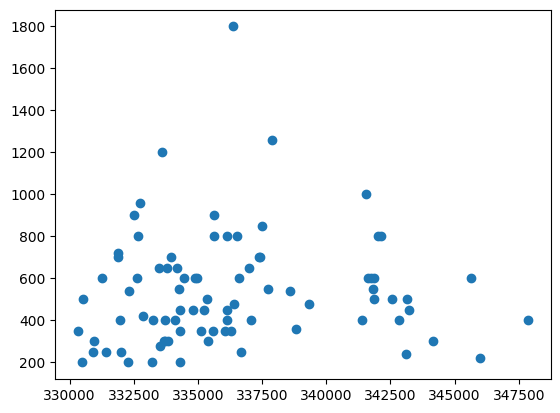

In [5]:
plt.scatter(x,q)

#### Plot between y and Q(lpm)

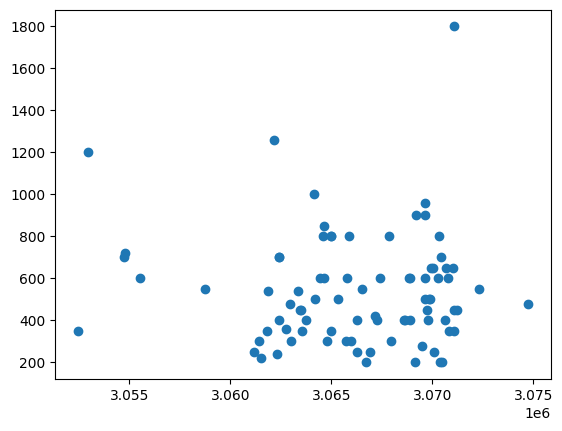

In [6]:
plt.scatter(y,q)

#### Scatter Plot of Discharge Data (Colorbar indicates discharge in lpm)

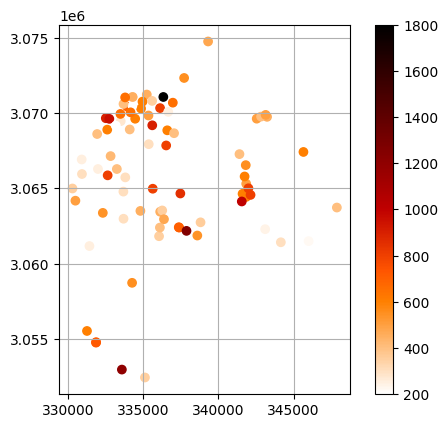

In [7]:
plt.gca().set_aspect('equal')
plt.grid()
plt.scatter(x, y, c=q, cmap='gist_heat_r')
plt.colorbar()

#### Triangulated Contour Filled Plot

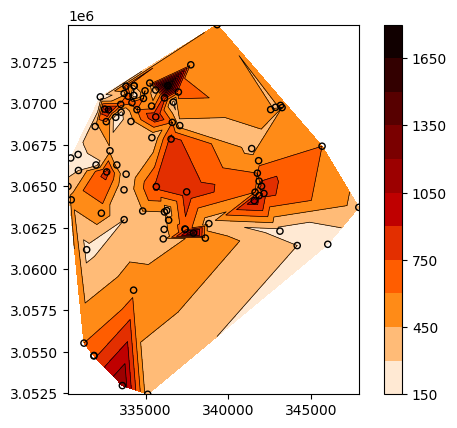

In [8]:
z = q
# create plot
fig, ax = plt.subplots(nrows=1)

# contoure
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k') 
# filling
cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="gist_heat_r") 
# colorbar
fig.colorbar(cntr2, ax=ax)
# dots
ax.scatter(x, y,s = 20, facecolors='none', edgecolor='k') 
 
# Equal aspect ratio 
plt.gca().set_aspect('equal', adjustable='box')
# plt.clim(0.13,0.4) 
plt.show()

### Gaussian Regression Implementation

Normalize the discharge values

In [10]:
# Normalize discharge data:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
q_scaled = scaler.fit_transform(qdata.iloc[:,3].to_numpy().reshape(-1, 1))
df_normalized = pd.Series(q_scaled.flatten(), index=q.index)
qdata['Q_lpm_normalized'] = pd.Series(q_scaled.flatten(), index=q.index)
# df_normalized


Shuffle the dataframe and divide train and test data:

In [20]:
#Shuffling the dataframe
shuffled_df = qdata.sample(frac=1, random_state=30) # frac=1 shuffles all rows, random_state for reproducibility
shuffled_df

,well,X_UTM,Y_UTM,Q_lpm,Q_lpm_normalized
72,Ratnapark well,333820.4642,3065731.906,300.0,-0.898627
30,BB-2,336978.2194,3070694.725,650.0,0.432337
10,Hepali Height Well,336348.4159,3071073.341,1800.0,4.805502
73,Sallagari Well,343112.2146,3062290.601,240.0,-1.126792
8,Damaichaghat well,332649.6046,3065867.665,800.0,1.002750
...,...,...,...,...,...
12,Kausaltar Tube Well,338605.9825,3061868.624,540.0,0.014034
81,Sukedhara well,337060.4114,3068666.772,400.0,-0.518351
45,Danfe Colony well,335603.5148,3070813.024,350.0,-0.708489
83,Tripureshwor well,333694.0924,3064786.137,300.0,-0.898627


In [17]:
# 70%
mid = int(len(qdata)* 0.70)   # m = integer midpoint of the overall dataframe for equal distribution of training and testing data.
mid


58

In [24]:
shuffled_df.iloc[:mid,1:3].to_numpy()
shuffled_df.iloc[:mid,4].to_numpy()


array([-0.89862667,  0.43233676,  4.80550231, -1.12679183,  1.00274966,
        0.24219913, -1.20284688,  2.75201588, -1.0887643 ,  0.43233676,
       -0.70848904, -0.13807614,  0.05206149,  1.38302492,  0.43233676,
       -0.5183514 , -0.89862667, -0.21413119, -0.70848904, -0.32821377,
        0.24219913, -1.27890193,  0.24219913, -1.0887643 ,  1.19288729,
       -0.89862667,  1.38302492, -1.27890193,  0.62247439, -0.32821377,
       -0.5183514 ,  0.24219913, -0.97468172, -0.5183514 , -0.70848904,
        0.62247439, -0.13807614, -0.13807614, -0.89862667,  0.43233676,
        2.52385072, -1.0887643 , -0.32821377,  0.24219913, -0.32821377,
       -0.70848904, -0.5183514 ,  1.00274966,  0.24219913, -0.32821377,
        1.00274966, -0.13807614,  0.62247439, -0.44229635,  0.24219913,
       -0.5183514 , -0.5183514 , -0.13807614])

In [31]:
#Creating a model with RBF kernel

# kernel = gpy.kern.RBF(input_dim=2, variance = 5. , lengthscale=200.)

kernel = gpy.kern.RBF(input_dim=2, variance = 5. , lengthscale=200.)

in_data = shuffled_df.iloc[:mid,1:3].to_numpy()
out_data = shuffled_df.iloc[:mid,4:5].to_numpy()

m = gpy.models.GPRegression(in_data,out_data,kernel)

display(m)
m.optimize()
display(m)
# PGV_predicted_mean, PGV_predicted_var = m.predict(shuffled_df.iloc[850:,0:5].to_numpy())
# PGV_predicted_sd = PGV_predicted_var**0.5


GP_regression.,value,constraints,priors
rbf.variance,5.0,+ve,
rbf.lengthscale,200.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
rbf.variance,1.2060059955249935,+ve,
rbf.lengthscale,461.23515760064316,+ve,
Gaussian_noise.variance,0.04489972622599393,+ve,


### Prediction

In [32]:
q_predicted_mean, q_predicted_var = m.predict(shuffled_df.iloc[mid:,1:3].to_numpy())
q_predicted_sd = q_predicted_var**0.5

### Plotting and Visualizing the model

In [47]:
q_trans_mean = scaler.inverse_transform(q_predicted_mean)
q_trans_var = scaler.inverse_transform(q_predicted_var)

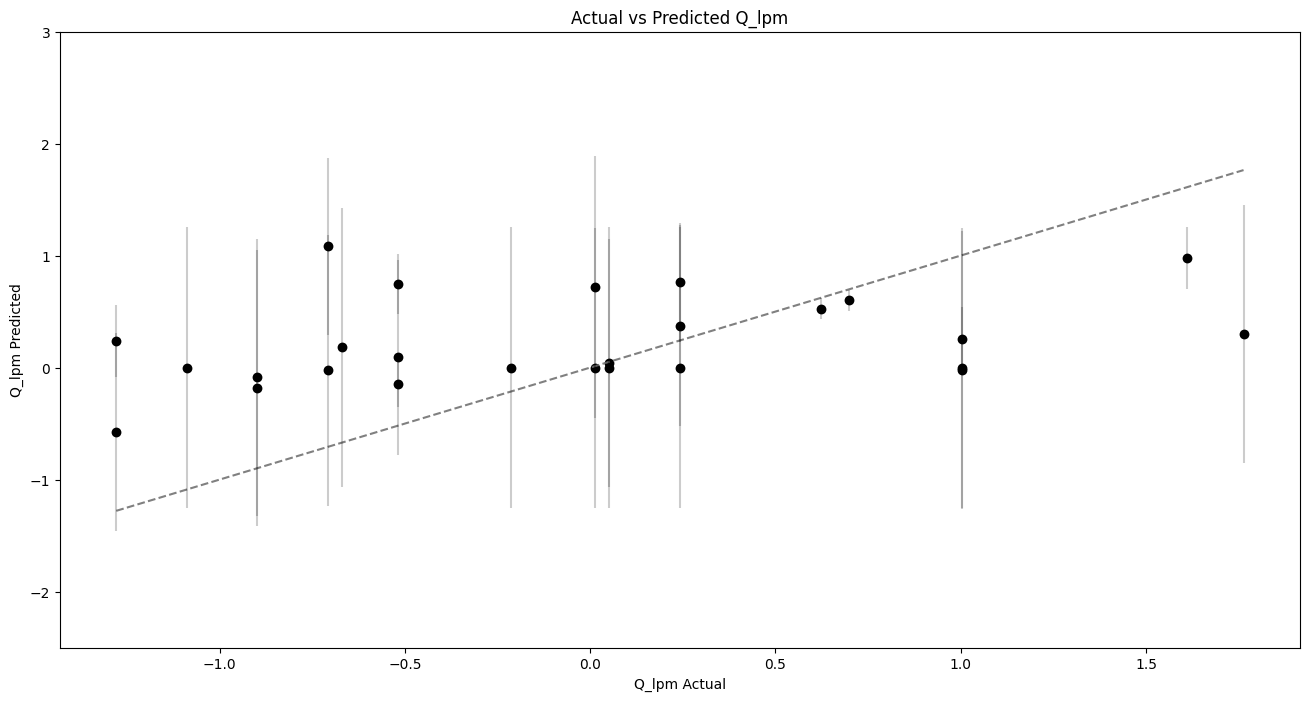

<Figure size 640x480 with 0 Axes>

In [45]:

plt.figure(figsize=(16,8))
q_test= shuffled_df.iloc[mid:,4:5].to_numpy()

# Plot act = pred line.
x = np.linspace(q_test[:, 0].min(), q_test[:, 0].max(), 100)
plt.plot(x, x, '--', color='gray')

# Plot scatter plot for actual vs predicted q_lpm for test data set. 
plt.scatter(q_test, q_predicted_mean, color='k')
plt.errorbar(q_test.flatten(), q_predicted_mean.flatten(), q_predicted_var.flatten(), fmt='o', color='k', alpha = 0.2)

# Labels and graphics
plt.xlabel("Q_lpm Actual")
plt.ylabel("Q_lpm Predicted")
plt.title("Actual vs Predicted Q_lpm")
plt.ylim((-2.5, 3))


# Visualize
plt.show()
plt.savefig("Qact_Qpre.png", dpi = 150)

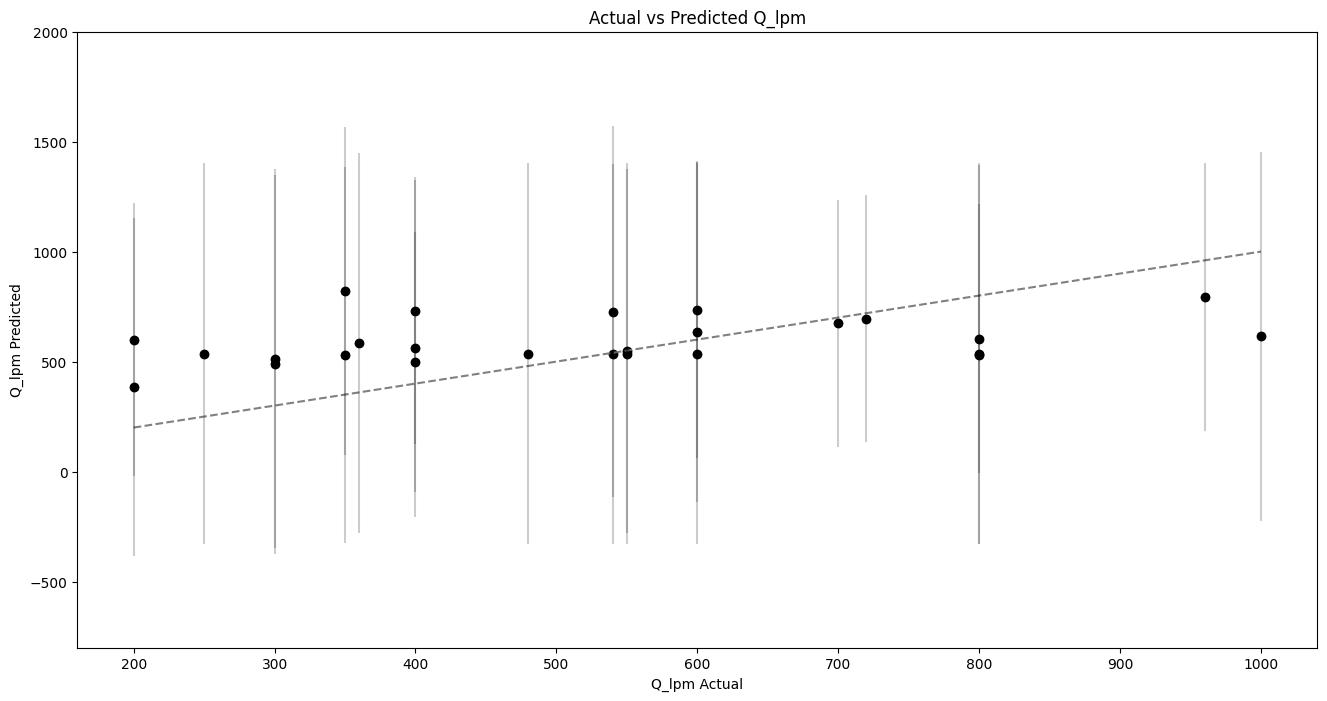

In [55]:

plt.figure(figsize=(16,8))
q_test= shuffled_df.iloc[mid:,3:4].to_numpy()

# Plot act = pred line.
x = np.linspace(q_test[:, 0].min(), q_test[:, 0].max(), 100)
plt.plot(x, x, '--', color='gray')

# Plot scatter plot for actual vs predicted q_lpm for test data set. 
plt.scatter(q_test, q_trans_mean, color='k')
plt.errorbar(q_test.flatten(), q_trans_mean.flatten(), q_trans_var.flatten(), fmt='o', color='k', alpha = 0.2)

# Labels and graphics
plt.xlabel("Q_lpm Actual")
plt.ylabel("Q_lpm Predicted")
plt.title("Actual vs Predicted Q_lpm")
plt.ylim((-800, 2000))

# Visualize
plt.savefig("images\Qact_Qpre.jpg", dpi = 150)
plt.show()

#### Visualize 2D input and Discharge output

(-2.5, 2.5)

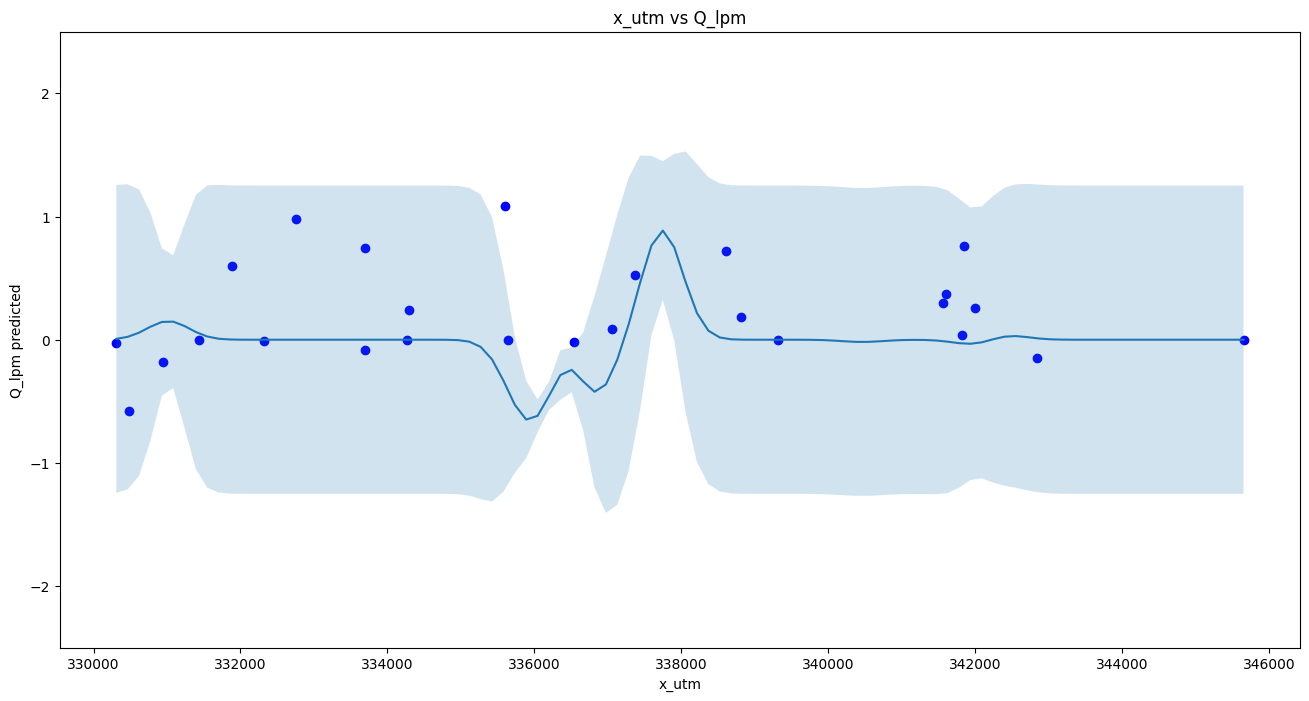

In [ ]:
x_lin = np.linspace(xy[:,0].min(), xy[:,0].max(), 100)
y_lin = np.linspace(xy[:,1].min(), xy[:,1].max(), 100)
q_pr, q_var =m.predict(pd.DataFrame({'x': x_lin, 'y': y_lin }).to_numpy())


plt.figure(figsize=(16,8))

plt.plot(x_lin,q_pr)
plt.scatter(shuffled_df.iloc[mid:,1:2].to_numpy(), q_predicted_mean, color='blue') 
plt.fill_between(x_lin, (q_pr - q_var).flatten(), (q_pr + q_var).flatten(), alpha = 0.2)

# Labels and graphics
plt.xlabel("x_utm")
plt.ylabel("Q_lpm predicted")
plt.title("x_utm vs Q_lpm")
plt.ylim((-2.5, 2.5))



### Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(q_test, q_predicted_mean)
mae = mean_absolute_error(q_test, q_predicted_mean)
r2 = r2_score(q_test, q_predicted_mean)
print("PGV Metrics")
print("MSE", mse)
print("MAE", mae)
print("R2 Score", r2)

PGV Metrics
MSE 0.6821085085675241
MAE 0.6682820465503551
R2 Score 0.022063898229291


### Plotting Varaince Fill